### EffecientNET

EfficientNet, first introduced in Tan and Le, 2019 is among the most efficient models (i.e. requiring least FLOPS for inference) that reaches State-of-the-Art accuracy on both imagenet and common image classification transfer learning tasks.

The smallest base model is similar to MnasNet, which reached near-SOTA with a significantly smaller model. By introducing a heuristic way to scale the model, EfficientNet provides a family of models (B0 to B7) that represents a good combination of efficiency and accuracy on a variety of scales. Such a scaling heuristics (compound-scaling, details see Tan and Le, 2019) allows the efficiency-oriented base model (B0) to surpass models at every scale, while avoiding extensive grid-search of hyperparameters.

A summary of the latest updates on the model is available, where various augmentation schemes and semi-supervised learning approaches are applied to further improve the imagenet performance of the models. These extensions of the model can be used by updating weights without changing model architecture.

### B0 to B7 variants of EfficientNET

Based on the original paper people may have the impression that EfficientNet is a continuous family of models created by arbitrarily choosing scaling factor in as Eq.(3) of the paper. However, choice of resolution, depth and width are also restricted by many factors:

- Resolution: Resolutions not divisible by 8, 16, etc. cause zero-padding near boundaries of some layers which wastes computational resources. This especially applies to smaller variants of the model, hence the input resolution for B0 and B1 are chosen as 224 and 240.
- Depth and width: The building blocks of EfficientNet demands channel size to be multiples of 8.
- Resource limit: Memory limitation may bottleneck resolution when depth and width can still increase. In such a situation, increasing depth and/or width but keep resolution can still improve performance.

As a result, the depth, width and resolution of each variant of the EfficientNet models are hand-picked and proven to produce good results, though they may be significantly off from the compound scaling formula. Therefore, the keras implementation (detailed below) only provide these 8 models, B0 to B7, instead of allowing arbitray choice of width / depth / resolution parameters.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("Invalid device or cannot modify virtual devices once initialized.")

In [3]:
IMG_SIZE = 224

In [4]:
batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split = ["train", "test"], with_info = True, as_supervised = True
)
NUM_CLASSES = ds_info.features["label"].num_classes

In [5]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

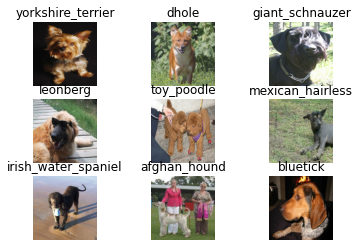

In [6]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

### Data augmentation

In [7]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor = 0.15),
        preprocessing.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor = 0.1),
    ],
    name = "img_augmentation",
)

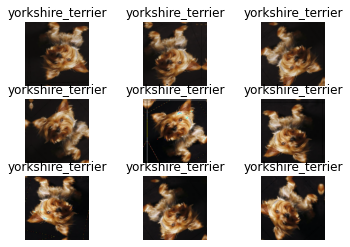

In [8]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis = 0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

### Prepare inputs

In [9]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls = tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder = True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size = batch_size, drop_remainder = True)

### Training

In [10]:
inputs = layers.Input(shape = (IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
outputs = EfficientNetB0(include_top = True, weights = None, classes = NUM_CLASSES)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]
)

model.summary()

epochs = 5  
hist = model.fit(ds_train, epochs = epochs, validation_data = ds_test, verbose = 1)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 120)               4203291   
Total params: 4,203,291
Trainable params: 4,161,268
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/5
      2/Unknown - 0s 216ms/step - loss: 5.2125 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1297s vs `on_train_batch_end` time: 0.3010s). Check your callbacks.


    187/Unknown - 76s 409ms/step - loss: 4.9494 - accuracy: 0.0116WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0271s vs `on_test_batch_end` time: 0.0419s). Check your callbacks.


187/187 [==============================] - 91s 489ms/step - loss: 4.9494 - accuracy: 0.0116 - val_loss: 4.8937 - val_accuracy: 0.0058
Epoch 2/5
187/187 [==============================] - 90s 483ms/step - loss: 4.6178 - accuracy: 0.0213 - val_loss: 4.9962 - val_accuracy: 0.0138
Epoch 3/5
187/187 [==============================] - 91s 486ms/step - loss: 4.4602 - accuracy: 0.0307 - val_loss: 4.4640 - val_accuracy: 0.0399
Epoch 4/5
187/187 [==============================] - 90s 483ms/step - loss: 4.3251 - accuracy: 0.0422 - val_loss: 4.3516 - val_accuracy: 0.0528
Epoch 5/5
187/187 [==============================] - 91s 486ms/step - loss: 4.1987 - accuracy: 0.0543 - val_loss: 4.8250 - val_accuracy: 0.0308


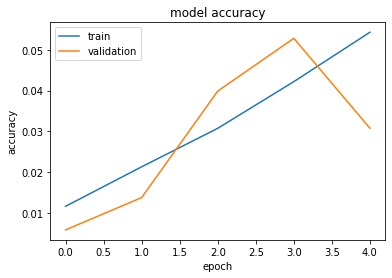

In [11]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc = "upper left")
    plt.show()

plot_hist(hist)